# Mask R-CNN - Inspect Nucleus Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
# os.chdir("/media/kai/setup/HungLX/data_science_bowl_2018/codes")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

# import mrcnn.model as modellib
import model as modellib

import train, predict
import balloon
from config import KaggleBowlConfig

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


Using TensorFlow backend.


In [10]:
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
TEST_MODE = "inference"


def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

train_path = '../data/stage1_train_test/'
dataset = train.InspectDataset()
dataset.load_shapes(["testing"], train_path)
dataset.prepare()
dataset.num_images

1

## Load Model

In [13]:
config = KaggleBowlConfig()
config.GPU_COUNT = 1
config.IMAGES_PER_GPU = 1
config.BATCH_SIZE = 1
# config.display()
model = predict.get_model(config, model_path="mask_rcnn.h5")


Loading weights from  mask_rcnn.h5


## Run Detection

Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  198.00000
molded_images            shape: (1, 512, 512, 3)      min:  -72.90000  max:   81.20000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000
Num: 16
auto show: False


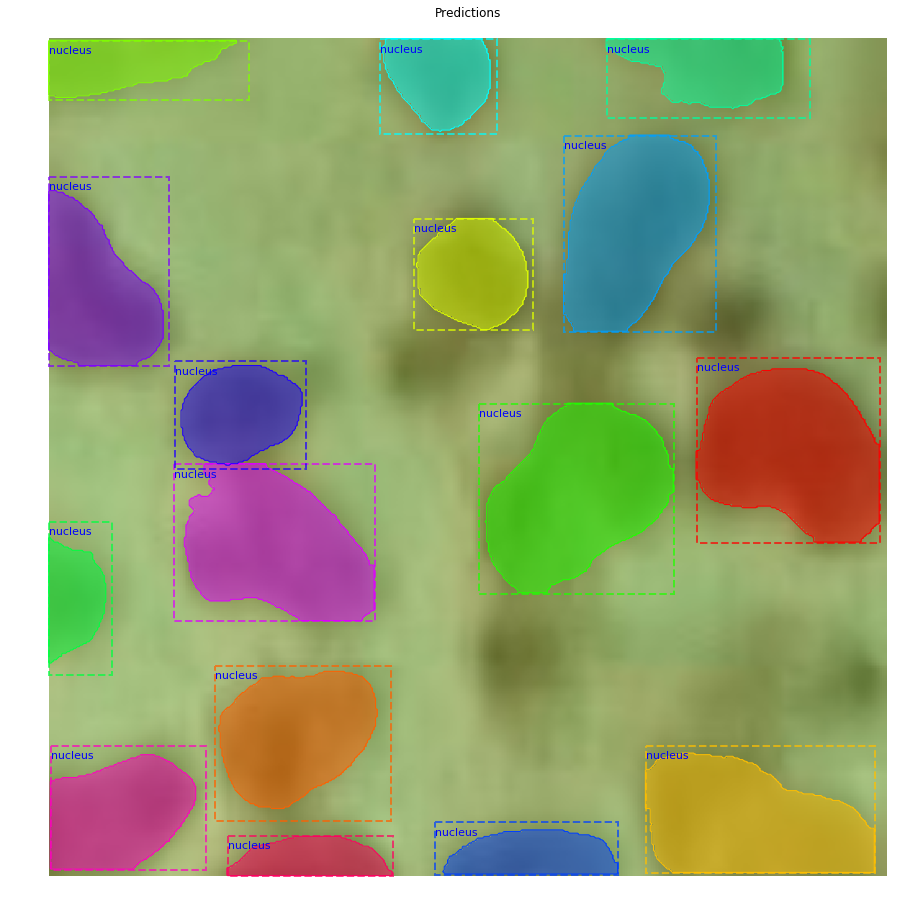

In [14]:
import cv2

# image_id = random.choice(dataset.image_ids)
image_id = 0
image = dataset.load_image(0, color="BGR")
image = cv2.resize(image, (512, 512))
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
print("Num:", len(r["rois"]))

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")


## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

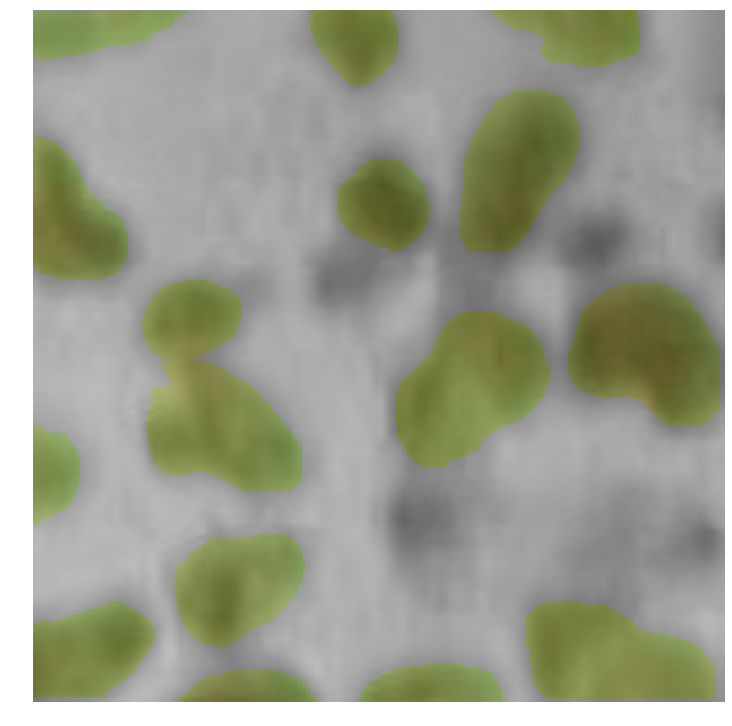

In [15]:
splash = balloon.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [16]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min:  -90.50967  max:  538.50964
refined_anchors          shape: (1, 6000, 4)          min: -143.91290  max:  923.70398
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:  512.00000
post_nms_anchor_ix       shape: (2048,)               min:    0.00000  max: 2598.00000
proposals                shape: (1, 2048, 4)          min:    0.00000  max:    1.00000


Number of anchors: 65472


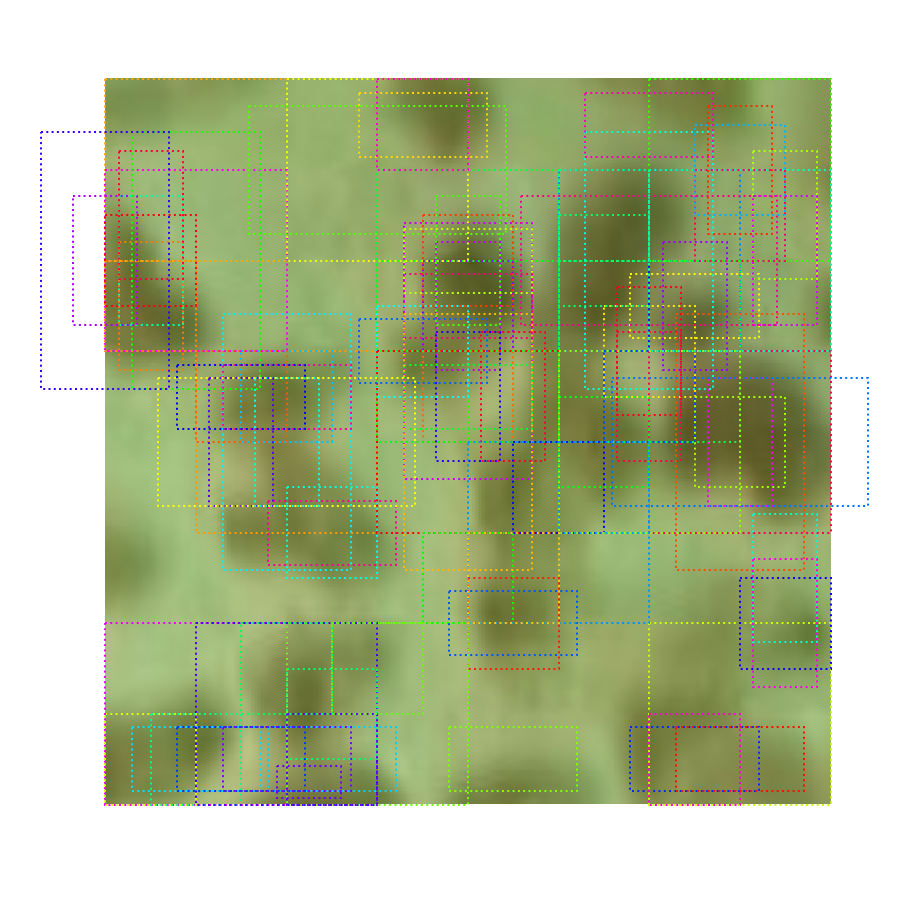

In [17]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
print("Number of anchors:", len(sorted_anchor_ids))

visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())



50
[[116.67932 221.3113  187.06476 294.6157 ]
 [122.12619 370.80634 191.25998 450.71835]
 [109.51523 221.2838  175.27246 296.49796]
 ...
 [191.90134 230.33739 416.71887 410.97516]
 [461.26978 172.7241  468.4742  179.79134]
 [425.4497  261.80716 431.35236 266.65427]]


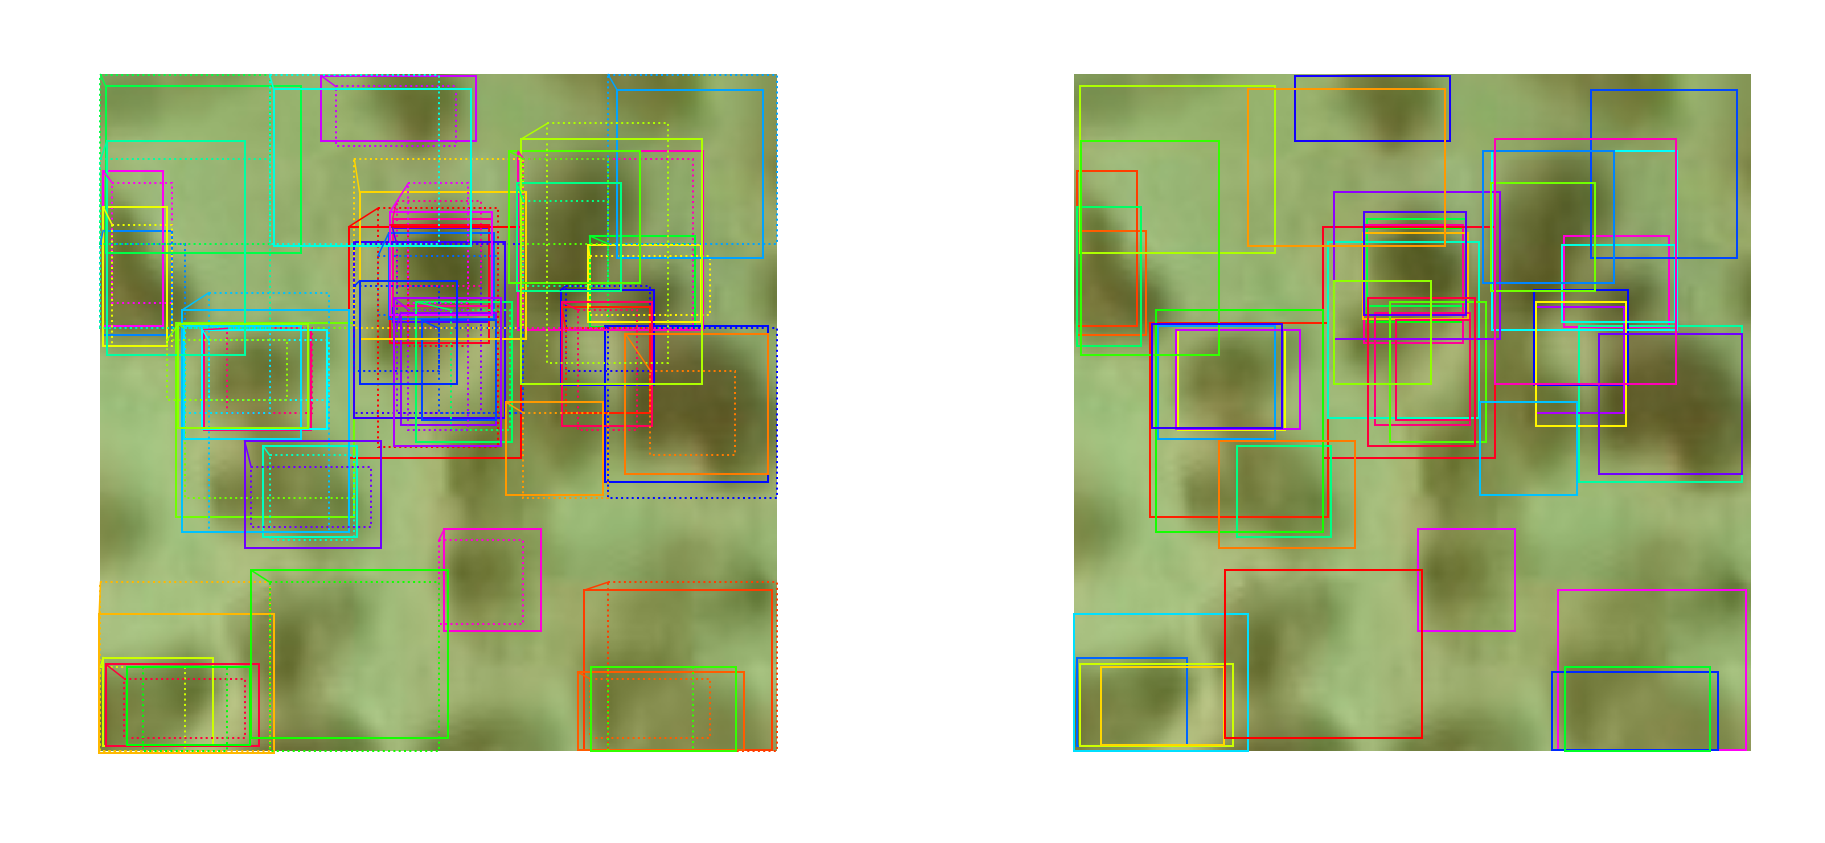

In [18]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
# pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
# refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])

pre_nms_anchors = rpn["pre_nms_anchors"][0].astype(np.int)
refined_anchors = rpn["refined_anchors"][0].astype(np.int)


# refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
refined_anchors_clipped = rpn["refined_anchors_clipped"][0].astype(np.int)

visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

print(len(refined_anchors_clipped[:limit]))
print(rpn["refined_anchors_clipped"][0])


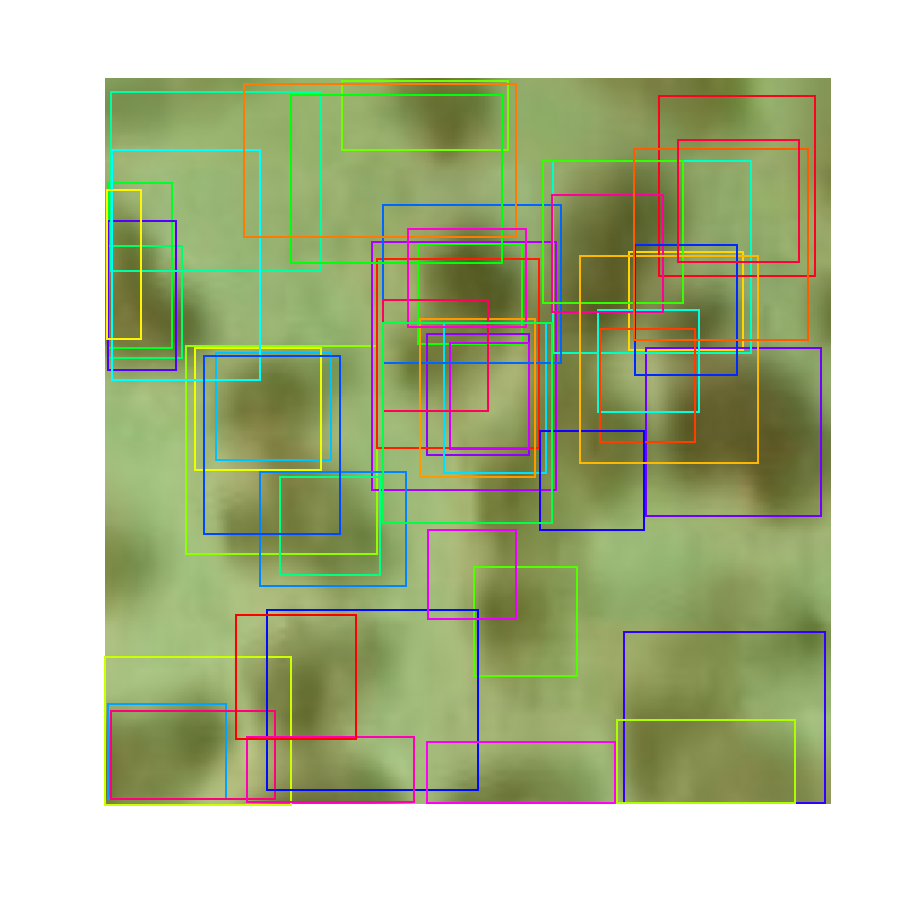

In [19]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

# print(rpn["post_nms_anchor_ix"])

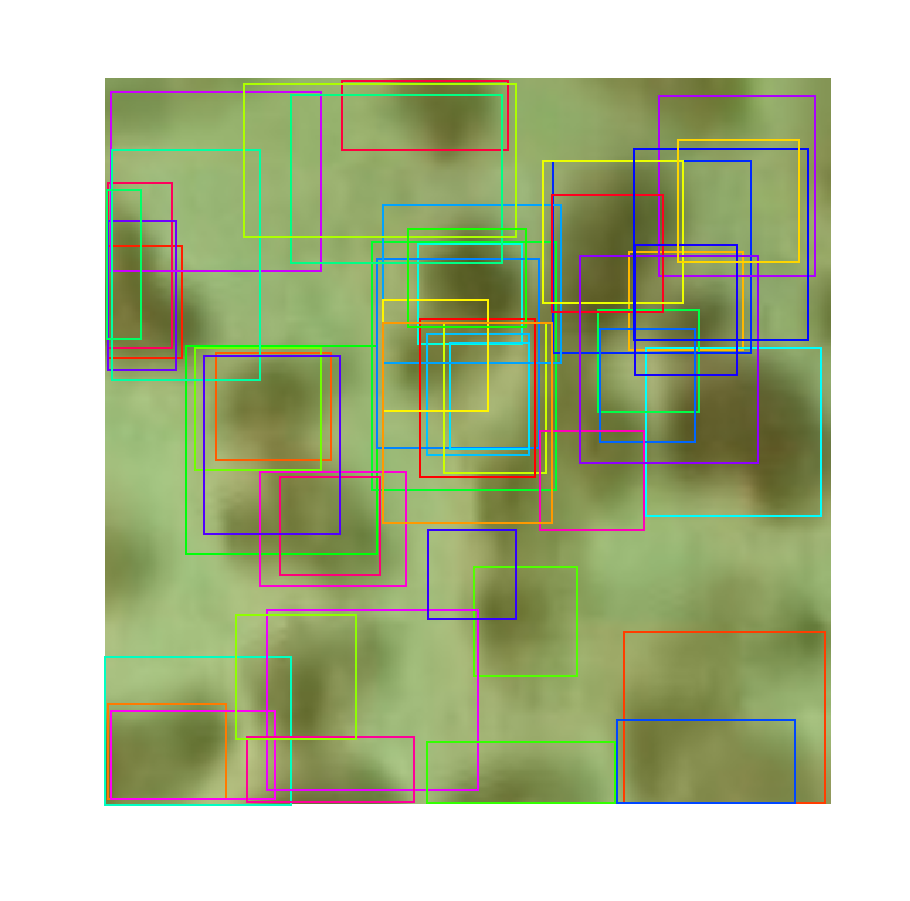

In [20]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [21]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 2048, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 2048, 2)          min:    0.00000  max:    1.00000
deltas                   shape: (1, 2048, 2, 4)       min:   -3.78881  max:    5.23964
masks                    shape: (1, 400, 28, 28, 2)   min:    0.00026  max:    0.99994
detections               shape: (1, 400, 6)           min:    0.00000  max:  512.00000


16 detections: ['nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus'
 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus'
 'nucleus' 'nucleus']


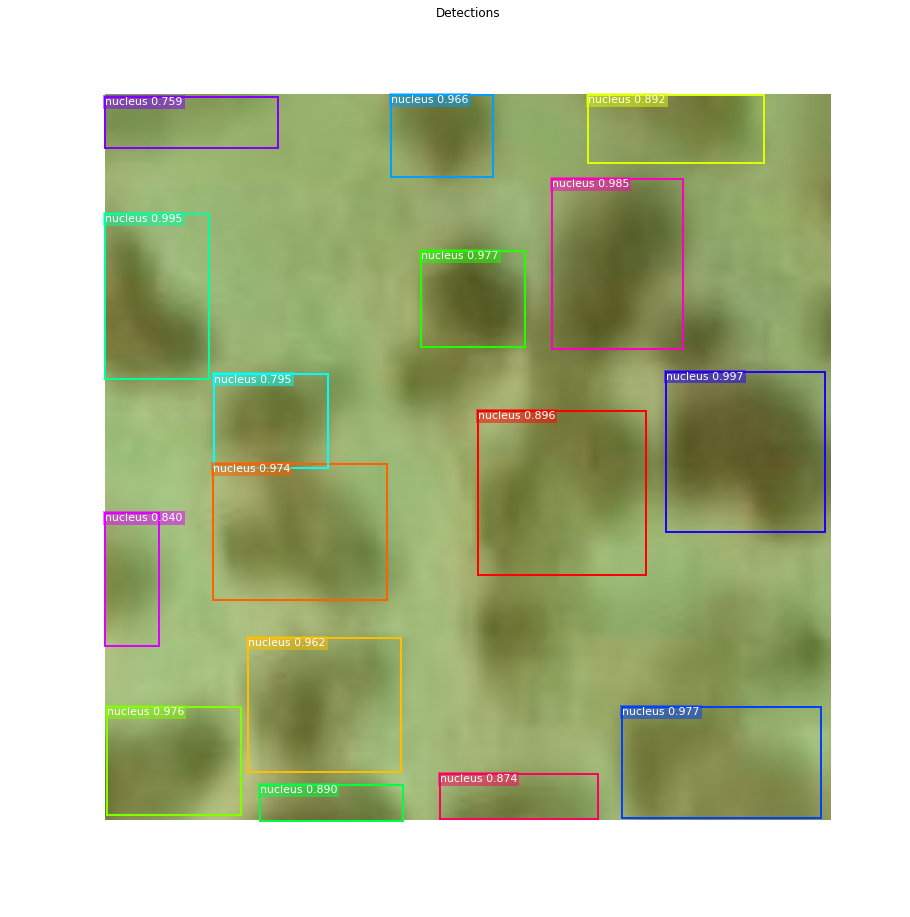

In [22]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]


print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
#     refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    refined_boxes = detections[:, :4].astype(np.int),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [23]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

2048 Valid proposals out of 2048
160 Positive ROIs
[('BG', 1888), ('nucleus', 160)]


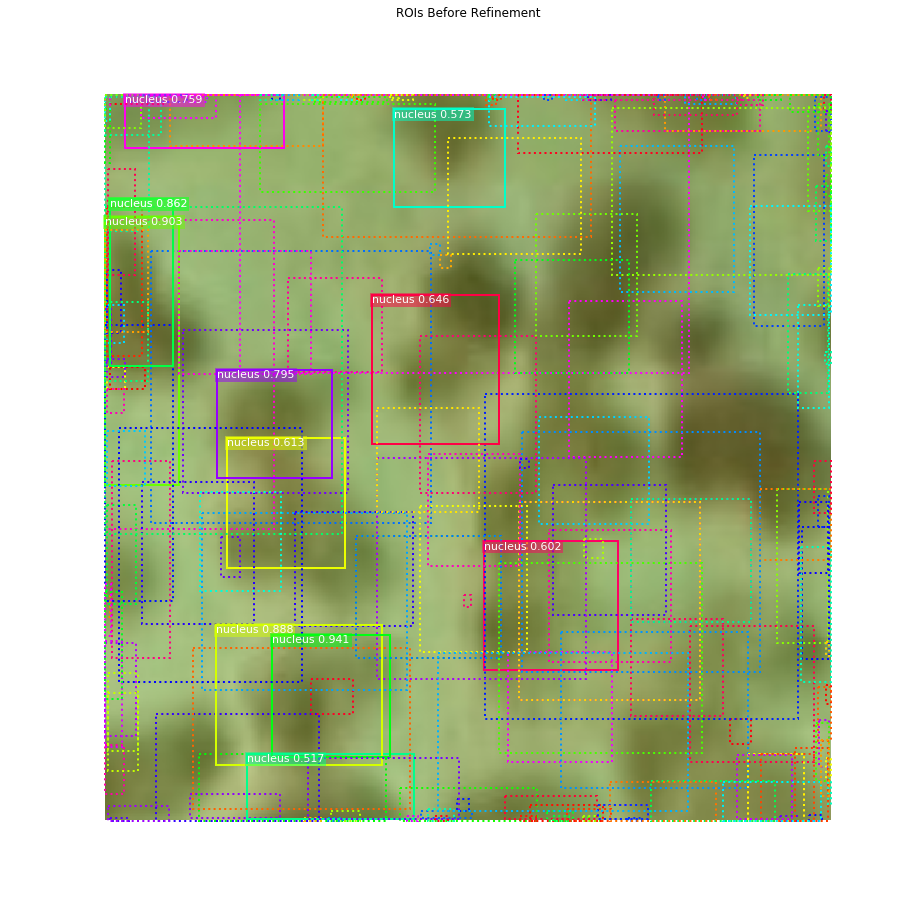

In [24]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (2048, 4)             min:   -3.16043  max:    5.23964  float32
refined_proposals        shape: (2048, 4)             min:  -13.00000  max:  529.00000  int32


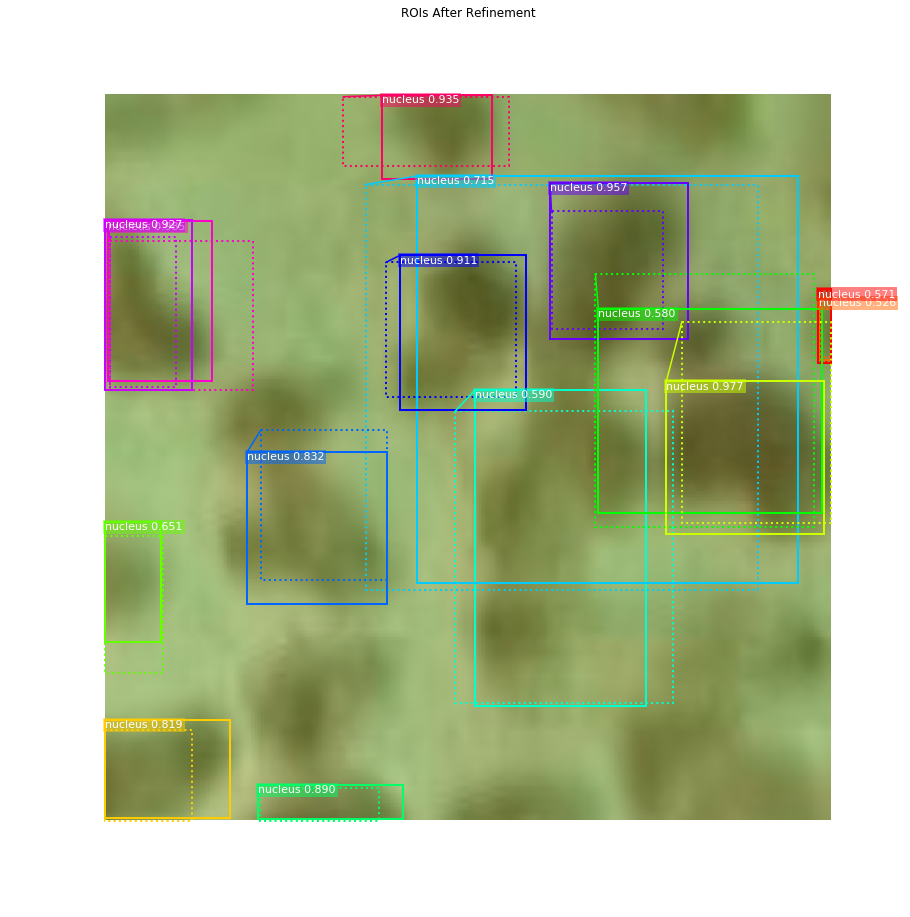

In [25]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 15
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [26]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 160 detections:
[   0    2    3    7    8   10   14   17   18   19   20   22   23   24
   25   26   28   30   31   36   40   41   42   47   49   54   55   58
   59   62   64   71   76   77   78   79   80   83   84   88   89   90
   92   94   96   98   99  100  104  105  106  107  108  110  115  117
  124  128  131  134  135  139  142  148  150  152  155  163  165  171
  176  178  179  188  190  200  206  210  212  216  221  224  231  233
  239  245  246  249  250  257  269  271  276  282  297  298  304  323
  358  359  360  365  368  382  383  386  420  422  426  440  448  449
  493  505  531  540  549  558  560  602  633  645  656  660  671  693
  694  745  759  781  800  815  846  855  871  884  899  937  948  953
  960  987 1007 1016 1030 1048 1061 1101 1158 1170 1294 1369 1448 1546
 1662 1678 1760 1915 1920 1931]


In [27]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.75 confidence. Keep 95:
[   0    2    3    7   10   14   17   18   19   20   22   23   24   25
   26   28   30   31   36   41   47   49   54   55   58   59   62   71
   77   78   79   80   83   88   89   94   96   99  100  104  106  107
  108  115  124  128  135  150  152  165  176  210  216  233  239  245
  249  257  276  297  298  304  358  359  360  365  382  386  422  426
  448  449  493  505  540  558  560  645  660  693  694  781  800  815
  937  960  987 1048 1158 1369 1448 1546 1678 1760 1931]


#### Per-Class Non-Max Suppression

In [28]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

nucleus               : [   0    2    3    7   10   14   17   18   19   20   22   23   24   25
   26   28   30   31   36   41   47   49   54   55   58   59   62   71
   77   78   79   80   83   88   89   94   96   99  100  104  106  107
  108  115  124  128  135  150  152  165  176  210  216  233  239  245
  249  257  276  297  298  304  358  359  360  365  382  386  422  426
  448  449  493  505  540  558  560  645  660  693  694  781  800  815
  937  960  987 1048 1158 1369 1448 1546 1678 1760 1931] -> [ 426  560   30   41 1931  108  815   54  233  135  176   62   49 1546
   10 1158]

Kept after per-class NMS: 16
[  10   30   41   49   54   62  108  135  176  233  426  560  815 1158
 1546 1931]


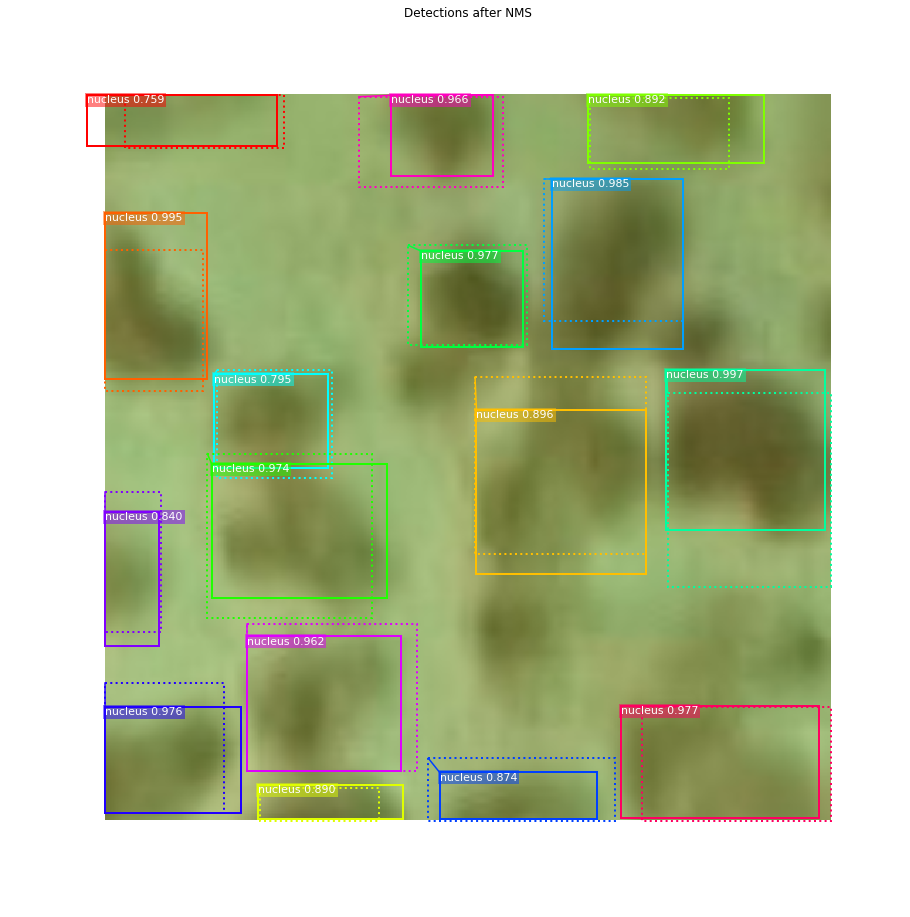

In [29]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [30]:
# display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [31]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 400, 6)           min:    0.00000  max:  512.00000
masks                    shape: (1, 400, 28, 28, 2)   min:    0.00026  max:    0.99994
16 detections: ['nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus'
 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus' 'nucleus'
 'nucleus' 'nucleus']


In [32]:
# Masks
# det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int)

det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (16, 28, 28)          min:    0.00026  max:    0.99994  float32
det_masks                shape: (16, 512, 512)        min:    0.00000  max:    1.00000  bool


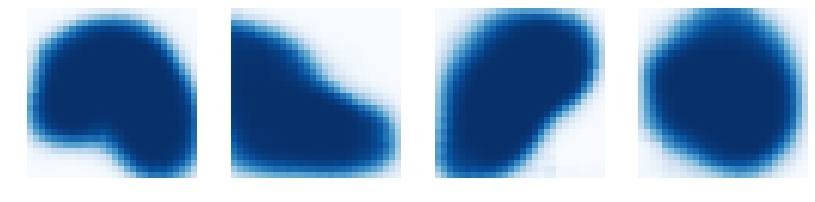

In [33]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

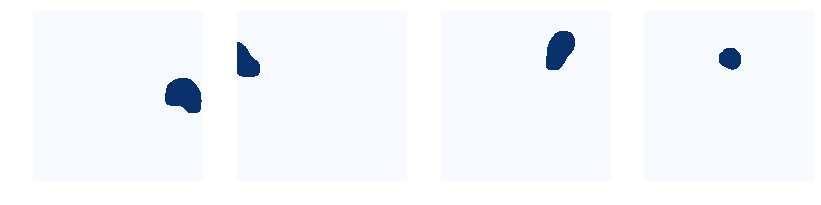

In [34]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [35]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min:  -72.90000  max:   81.20000
res2c_out                shape: (1, 128, 128, 256)    min:    0.00000  max:    7.05293
res3c_out                shape: (1, 64, 64, 512)      min:    0.00000  max:    8.73293
res4w_out                shape: (1, 32, 32, 1024)     min:    0.00000  max:    5.63757
rpn_bbox                 shape: (1, 65472, 4)         min:   -7.01840  max:   24.80016
roi                      shape: (1, 2048, 4)          min:    0.00000  max:    1.00000


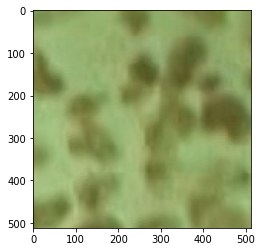

In [36]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

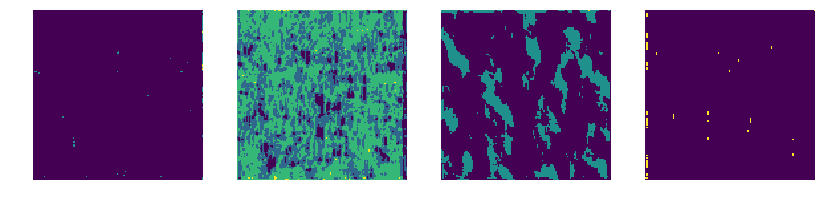

In [37]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)